# ***CT scan simulator***

In [8]:
from PIL import Image
import math
import matplotlib.pyplot as plt
from skimage.io import imread
from ipywidgets import *
from skimage import color
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
import datetime
import ipywidgets as widgets
from scipy import signal as sig
import numpy as np
from scipy import ndimage
%matplotlib notebook

### Bresenham's algorithm

In [2]:
def bresenham(x0,y0,x1,y1):
  dx = x1-x0
  dy = y1-y0
  x_sign = 1 if dx > 0 else -1
  y_sign = 1 if dy > 0 else -1

  dx = abs(dx)
  dy = abs(dy)

  if dx > dy:
    xx, xy, yx, yy = x_sign, 0, 0, y_sign
  else:
    dx, dy = dy, dx
    xx, xy, yx, yy = 0, y_sign, x_sign, 0

  D = 2*dy-dx
  y=0

  for x in range(dx+1):
    yield x0 + x * xx+y*yx, y0+x*xy+y*yy
    if D >=0:
      y += 1
      D -= 2*dx
    D += 2*dy

### Radon transform

In [3]:
def radon(img, iterations):
  X = (img.shape[1])
  Y = (img.shape[0])

  R = int(np.sqrt(X**2 + Y**2)/2)

  x_frame = int((2*R - X)/2)
  y_frame = int((2*R - Y)/2)
  img_frame = np.zeros((2*R, 2*R))
  for i in range(Y):
    for j in range(X):
      img_frame[i+y_frame][j+x_frame] = img[i][j]

  sinogram = np.zeros((iterations, n))
  emiter = [0, 0]
  detector = [0, 0]
  max_val = 0
  for emiter_index in range(iterations):
    emiter_angle = emiter_index*delta_alfa_r 
    emiter[0] = int(R*math.cos(math.pi/2 + emiter_angle))
    emiter[1] = int(R*math.sin(math.pi/2 + emiter_angle))

    for detector_index in range(n):
      detector[0] = int(R*math.cos(math.pi/2 + math.pi - (l/2) + detector_index*(l/(n-1))+(emiter_index*delta_alfa_r)))
      detector[1] = int(R*math.sin(math.pi/2 + math.pi - (l/2) + detector_index*(l/(n-1))+(emiter_index*delta_alfa_r)))      

      line = list(bresenham(emiter[0], emiter[1], detector[0], detector[1]))

      points_inside=0
      
      for i in line:
        if (x_frame<i[0]+R<x_frame+X and y_frame<i[1]+R<y_frame+Y):
          sinogram[emiter_index][detector_index] += img_frame[i[0]+R-1][i[1]+R-1]
          points_inside += 1

  return sinogram


### Filtering

In [4]:
def sinogram_filter(sinogram):
    h, w = np.shape(sinogram)
    filtered = []
    filter_arr = []
    for i in range (-7, 7):
        filter_arr.append(1) if i == 0 else filter_arr.append(0) if i % 2 == 0 else filter_arr.append(-4/(i*i*np.pi**2))
    for i in range(h):
        filtered.append(sig.convolve(sinogram[i], filter_arr, mode = 'same', method = 'direct'))
    return(np.array(filtered))
    

### Inverse Radon transform

In [5]:
def backprojection(sinogram, iterations):
  d = sinogram.shape[0]
  r = [x - sinogram.shape[0]/2 for x in np.arange(sinogram.shape[0])]
  rows, columns = np.meshgrid(r, r)
  iterations = int(180 / delta_alfa_d)
  display_all = []
  output = np.zeros((d, d))
  for i in range(iterations):
    display = np.zeros((d, d))
    rotation = rows * math.sin(i * delta_alfa_r) - columns * math.cos(i * delta_alfa_r)
    coord = (np.round((1/2) * d + rotation)).astype('int')

    coord1, coord2 = np.nonzero(np.logical_and(coord>=0, coord<d))
    line = sinogram[:, i-1]
    display[coord1, coord2] = line[coord[coord1, coord2]]

    output += display
    display_all.append(display)
  output = output // iterations
  return output, display_all


### Setting variables values and loading the image


In [22]:
img = imread("Shepp_logan.jpg", as_gray=True)

delta_alfa_d = 1 # step
delta_alfa_r = delta_alfa_d * np.pi/180 # step in radians
n = 360 # number of detectors
d = 360 # detectors range
l = d * np.pi/180 # detectors range in radians
sinogram = np.zeros((int(2 * np.pi / delta_alfa_r), n))

In [33]:
def setAlfa(alfa):
    global delta_alfa_r 
    global delta_alfa_d
    delta_alfa_r = alfa*math.pi/180
    delta_alfa_d = delta_alfa_r*180/math.pi
def setDetectorsNumber(detectorsNumber):
    global n 
    n = detectorsNumber
def setRange(degrees):
    global l 
    l = degrees*math.pi/180

interact(setAlfa,alfa=widgets.FloatSlider(description='Step:',min=0.25,max=5.0,step=0.25,value=delta_alfa_d))
interact(setDetectorsNumber,detectorsNumber=widgets.IntSlider(description='Detectors:',min=10,max=500,step=10,value=n))
interact(setRange,degrees=widgets.IntSlider(description='Range:',min=0,max=360,step=10,value=d))


interactive(children=(FloatSlider(value=1.0, description='Step:', max=5.0, min=0.25, step=0.25), Output()), _d…

interactive(children=(IntSlider(value=360, description='Detectors:', max=500, min=10, step=10), Output()), _do…

interactive(children=(IntSlider(value=360, description='Range:', max=360, step=10), Output()), _dom_classes=('…

<function __main__.setRange(degrees)>

### Input image, sinogram and output image display

In [34]:
sinogram = radon(img, round(360/delta_alfa_d)).T
output, l = backprojection(sinogram, int(360/delta_alfa_d))

In [116]:
#filtered_sinogram = sinogram_filter(sinogram)
#output_filter, l_filter = backprojection(filtered_sinogram, int(180/delta_alfa_d))

<IPython.core.display.Javascript object>


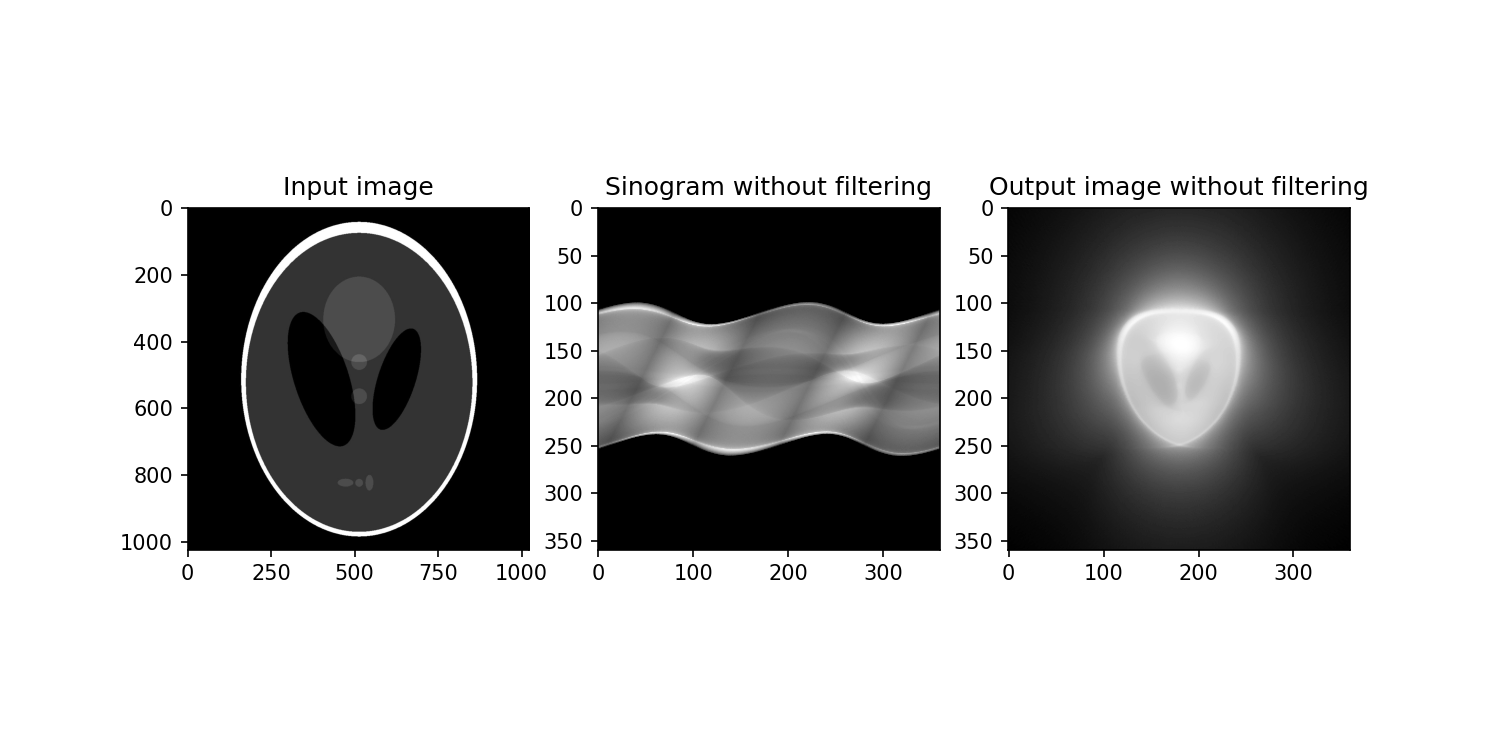

In [35]:
plt.figure(figsize=(10,5))

sub1 = plt.subplot(131)
sub1.imshow(img, cmap='gray')
sub1.set_title("Input image")

sub2 = plt.subplot(132)

sub2.imshow(sinogram, cmap='gray')
sub2.set_title("Sinogram without filtering")


sub3 = plt.subplot(133)
output = np.flipud(output)


sub3.imshow(output, cmap='gray')
sub3.set_title("Output image without filtering")

"""sub4 = plt.subplot(234)
sub4.imshow(filtered_sinogram, cmap='gray')
sub4.set_title("Sinogram with filtering")

sub5 = plt.subplot(235)
sub5.imshow(output_filter, cmap='gray')
sub5.set_title("Output image with filtering")"""

plt.show()

<IPython.core.display.Javascript object>


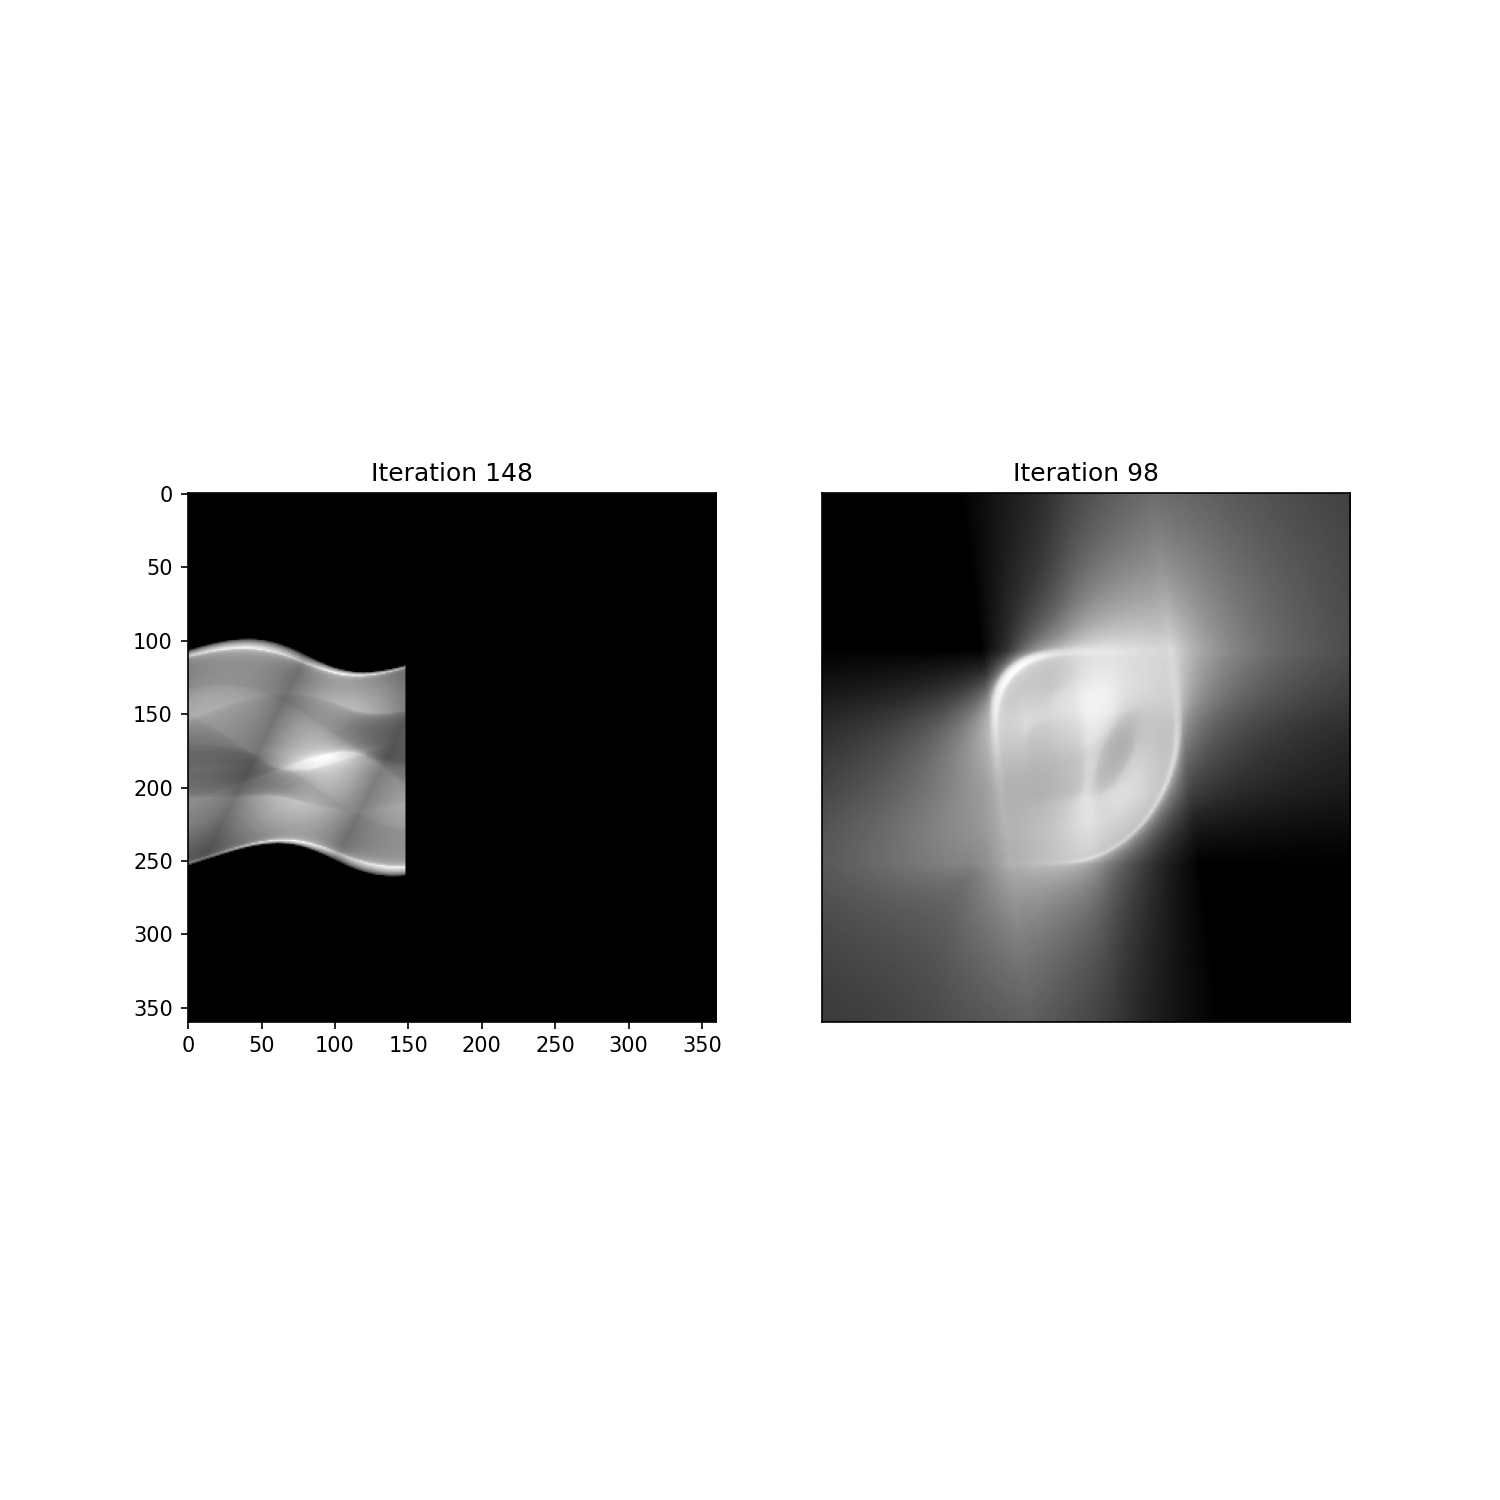

interactive(children=(IntSlider(value=360, description='Iterations:', max=360, min=1), Output()), _dom_classes…

interactive(children=(IntSlider(value=360, description='Iterations:', max=360, min=1), Output()), _dom_classes…

<function __main__.update_output(angles)>

In [37]:
global plt
plt.figure(figsize=(10,10))
xlabels=[i*20 for i in range(10)]


def update_sinogram(it):
    global sub3
    sub3 = plt.subplot(121)
    sub3.set_title(f"Iteration {it}")
    sinogram2 = np.array([[0 for i in range(len(sinogram[0]))] for j in range(len(sinogram))])
    sinogram2[:,:it] = sinogram[:,:it]
    sub3.imshow(sinogram2, cmap='gray')
    
    
def update_output(angles):
    angles = int(angles)
    reconstruction = sum(l[:angles])
    reconstruction = np.flipud(reconstruction)
    global sub4
    sub4 = plt.subplot(122)
    sub4.set_xticks([],[])
    sub4.set_yticks([],[])
    sub4.imshow(reconstruction, cmap='gray')
    sub4.set_title(f"Iteration {angles}")
    
interact(update_sinogram,it=widgets.IntSlider(description='Iterations:',min=1,max=int(360/delta_alfa_d),step=1,value=int(360/delta_alfa_d)))
interact(update_output,angles=widgets.IntSlider(description='Iterations:',min=1,max=int(360/delta_alfa_d),step=1,value=int(360/delta_alfa_d)))



### Writing and reading DICOM files

In [15]:
def save_dicom(img, filename, name, patientID, comment):
    dicom_img = (img).astype(np.uint16)

    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    ds = FileDataset(filename, {}, file_meta = meta, preamble=b"\0" * 128)

    ds.is_little_endian = True
    ds.is_implicit_VR = True

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID

    ds.PatientName = name
    ds.PatientID = patientID
    ds.ImageComments = comment
    dt = datetime.datetime.now()
    ds.Date = dt.strftime('%Y%m%d')

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.SamplesPerPixel = 1
    ds.HighBit = 15

    ds.InstanceNumber = 1
    
    ds.Rows = img.shape[0]
    ds.Columns = img.shape[1]
    
    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
    ds.PixelData = dicom_img.tobytes()
    name = filename + '.dcm'
    ds.save_as(name, write_like_original = False)

In [16]:
def read_dicom(filename):
  file = pydicom.dcmread(filename, force = True)
  name = file.PatientName
  patientID = file.PatientID
  comment = file.ImageComments

  print("Name: ", name)
  print("ID: ", patientID)
  
  try:
    date = file.Date
  except:
    print("Data: -")
  else:
    date = date[0:4]+"-"+date[4:6]+"-"+date[6:8]
    print("Date: " + date)

  print("Comments: " + comment)

  plt.imshow(file.pixel_array,cmap="gray")

Name:  name
ID:  id
Date: 2023-04-18
Comments: comment


<IPython.core.display.Javascript object>


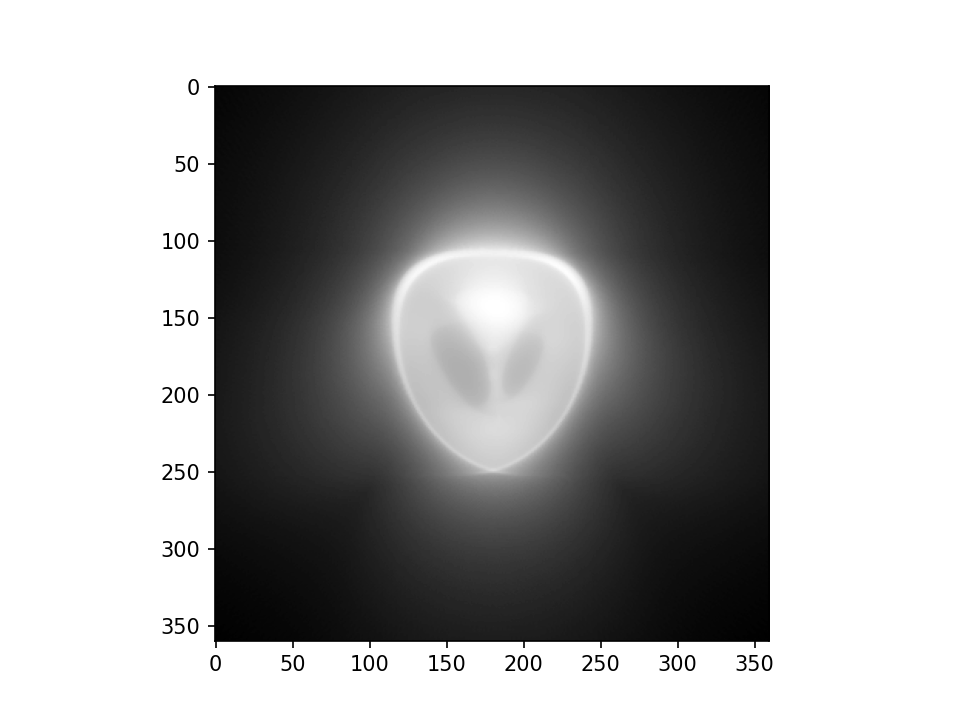

In [17]:
save_dicom(output, 'dicomfile', 'name', 'id', 'comment')
read_dicom('dicomfile.dcm')